      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 colu

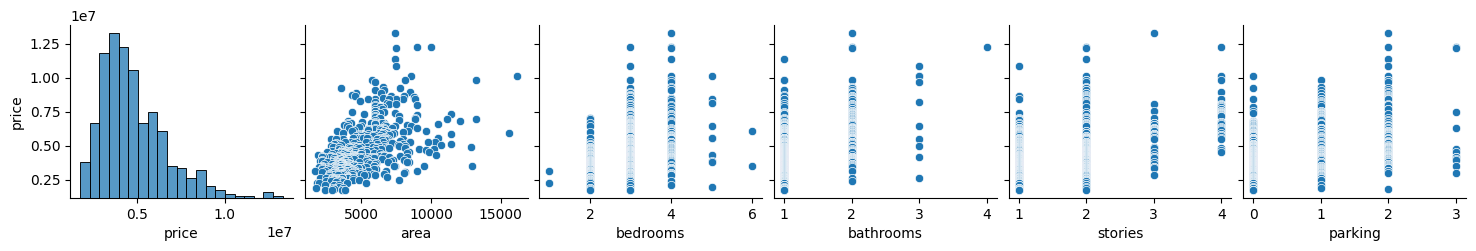

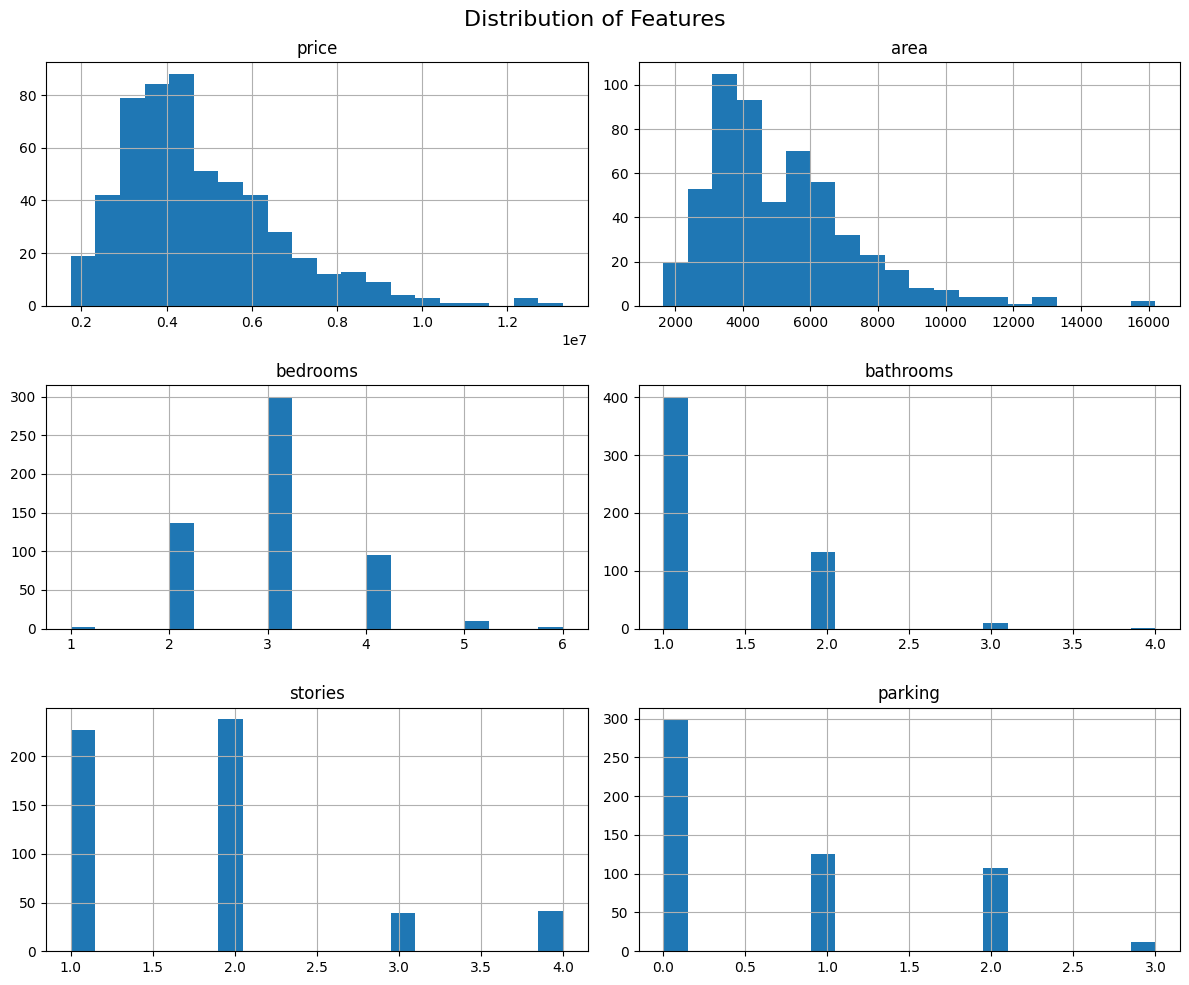

<ipython-input-2-32143bfc0c42>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing[col_to_scale] = Standard_Scaler.fit_transform(housing[col_to_scale])


Training Linear Regression...
Best parameters: {}
Root Mean Squared Error: 0.7281459439665595
R-squared: 0.619370114778371
--------------------
Training Ridge Regression...
Best parameters: {'alpha': 10}
Root Mean Squared Error: 0.7317022167374889
R-squared: 0.6156430343370272
--------------------
Training Decision Tree...
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Root Mean Squared Error: 0.8690335473137181
R-squared: 0.4578254866347685
--------------------
Training Random Forest...
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Root Mean Squared Error: 0.7870800662590904
R-squared: 0.5552624065934055
--------------------
Training XG Boost...
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Root Mean Squared Error: 0.7697164848806062
R-squared: 0.5746684582130246
--------------------
Mean Absolute Error (MAE): 0.50315798338

In [2]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # Import pickle for saving/loading models



# 1. Load and Explore Data (EDA)
housing = pd.read_csv("/content/Housing.csv")
print(housing.head()) # to view the head of the data
print(housing.info()) # to check the data types and null values in the data
print(housing.describe()) # to check the statistics of the data

# 2. Visualize Data and Correlations
sns.pairplot(housing, y_vars=['price'])  # Pairwise relationships with respect to 'price' since we are looking for factors that affect the price.
plt.show()


# 3. Visualize the distribution
housing.hist(figsize=(12, 10), bins=20)  # Adjust figsize and bins as needed
plt.suptitle("Distribution of Features", fontsize=16)  # Add a title
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



# 4. Analyze and Handle Outliers (Example using IQR)
# Choose a column to analyze for outliers ('area') since area is directly correlated to the price.
Q1 = housing['area'].quantile(0.25)
Q3 = housing['area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Decide how to handle outliers (e.g., remove, cap, transform)
housing = housing[(housing['area'] >= lower_bound) & (housing['area'] <= upper_bound)]  # Removing the outliers



# Scaling the numerical features
Standard_Scaler  = StandardScaler()
col_to_scale = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
housing[col_to_scale] = Standard_Scaler.fit_transform(housing[col_to_scale])


# One hot encoding the categorical features
housing = pd.get_dummies(housing, columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'])


# Dividing the dataset into independent features and the target variable
y=housing['price']
x=housing.drop('price',axis=1)


# Dividing the data into training and testing data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)



# We want to try multiple regression models and select the model with best results.
# Providing a dictionary of regression algorithms with hyperparameters to find the best parameters.
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters to tune for Linear Regression
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XG Boost': {
        'model' : XGBRegressor(),
        'params' : {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }

}


# Training each model one by one and finding the best parameters
for model_name, model_data in models.items():
    print(f"Training {model_name}...")

    model = model_data['model']
    params = model_data['params']

    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")
    print("-" * 20)


# Now that we have tested every model, we find that linear regression achieves the best results.
# So we train our final model through a pipeline with linear regression.

numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_features = [col for col in housing.columns if col not in numerical_features + ['price']] # This dynamically gets all columns except numerical features and price, which are your one-hot encoded columns


# Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),  # sparse=False for dense output
])

# Combine Pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()),
])

# Separate Features and Target
X = housing.drop('price', axis=1)
y = housing['price']

# 7. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train the Model
model_pipeline.fit(X_train, y_train)

# 9. Make Predictions
y_pred = model_pipeline.predict(X_test)

# 10. Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


# Saving the model
with open('linear_regression_model.pkl', 'wb') as file:
    loaded_model = pickle.dump(model_pipeline, file)

In [4]:
# Testing the saved model

data = X_train[100:500]

import pickle

with open('linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Make predictions
predictions = loaded_model.predict(data)
print(predictions)

mae = mean_absolute_error(y_train[100:500], predictions)
rmse = np.sqrt(mean_squared_error(y_train[100:500], predictions))
r2 = r2_score(y_train[100:500], predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


[ 1.41589385e+00 -2.02056025e-01  9.23807314e-01 -2.60872344e-01
 -3.40885734e-01 -1.01805479e+00 -1.77736727e-01 -6.32855470e-01
 -1.56872017e-01 -8.26374046e-01  6.17781960e-01 -3.40885734e-01
  1.17356702e+00  3.37216975e-01  5.54467216e-01  2.01146104e-01
 -1.09350315e+00 -9.20844516e-02  1.86254445e-01 -2.71568278e-01
 -4.43809650e-01  1.20750354e+00 -6.38683007e-01  4.74368527e-01
  1.15056970e+00  1.02240267e+00 -3.30546052e-01 -5.76585508e-01
 -1.39366940e+00 -1.28845001e+00  1.47669431e+00  9.35114965e-01
  5.36184114e-01  5.95819515e-01 -5.51163454e-01 -7.39475865e-01
  3.02970778e-01 -8.80679598e-01 -1.57353201e-01 -1.30013393e+00
  1.70022693e-01 -4.24792430e-01 -7.13028731e-01 -5.72011530e-01
 -8.09583845e-01 -9.21152007e-01 -4.32179508e-01 -8.22721270e-01
 -5.13262636e-01 -5.89275600e-01 -1.22427549e+00 -2.28276679e-01
  9.79803448e-01  2.85650173e-01 -3.36371445e-01  5.12459370e-01
  8.89735230e-01  1.53627576e-01 -1.01896673e+00  1.47238997e-02
 -3.84158171e-01  7.39455